ipykernel_launcher:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
ipykernel_launcher:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


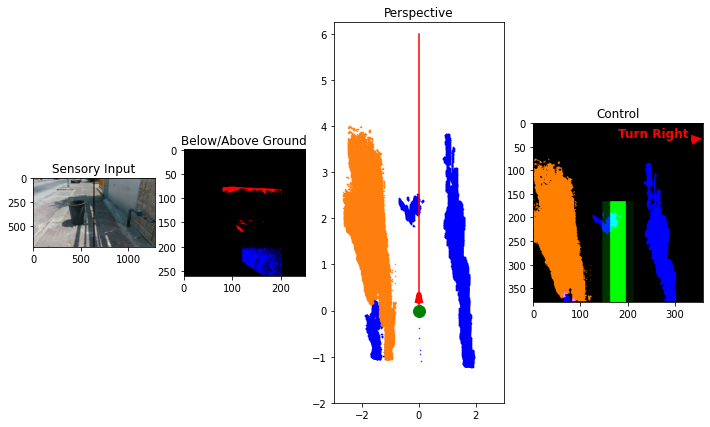

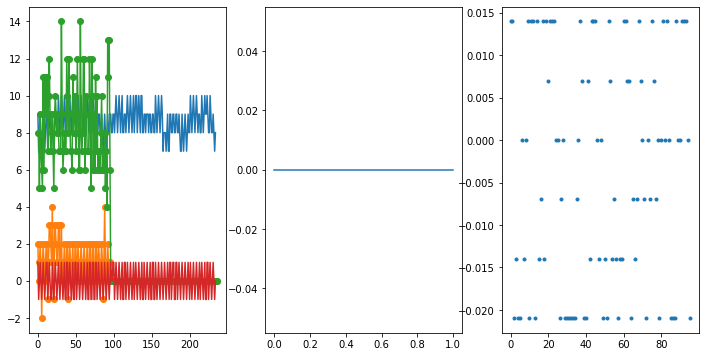

In [6]:
import tkinter
import matplotlib
#matplotlib.use('TkAgg')
from Modules.Control import Control
from Modules.scan_match import scan_match
from Modules.SLAM import SLAM
from Modules.plane_fit import plane_fit
from utils import *
frames_check = []
yawt_out = []

def run_algo(dxinternal,dyinternal,I,pcloud,pRGB1,yaw):
    tx=np.zeros((len(I),2))
    S=[]
    tr=[]
    tc=[]
    yawt = []
    dxIMU = np.round(dxinternal[3:-1]*1e3/sc)
    dyIMU = np.round(dyinternal[3:-1]*1e3/sc)
    xplus=np.array([]).reshape(0,2)
    xminus=np.array([]).reshape(0,2)
    x=[]
    tx_prev = []
    dummy_img = np.zeros((720,1280,3))
    dummy_glvl = np.zeros((260,250,3))
    gs_kw = dict(width_ratios=[5, 5,7,7])
    nav_arrow = []
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(12,7),gridspec_kw=gs_kw)
    dummy_ctrl = np.zeros((380,360,3))
    axCtrl_data = ax4.imshow(dummy_ctrl)
    fig.show()
    ax3.axis(np.array([-120,120,-80,250])/1e3*25)
    ax2_data = ax2.imshow(dummy_glvl)
    ax3_data1 = ax3.plot([],[],'.b',markersize=0.9)[0]
    ax3_data2 = ax3.plot([],[],'.C1',markersize=0.9)[0]
    ax3_data3 = ax3.plot([0,0],[0,6],'r')[0]
    ax3.plot(0/sc,0/sc,'o',linewidth=9,color = 'g',markersize=12)
    ax3.plot(np.array([-50,0,50])/1e3,np.array([210,350,210])/1e3,linewidth=5,color='r')
    ax1_data = ax1.imshow(dummy_img)
    ax1.title.set_text("Sensory Input")
    ax2.title.set_text("Below/Above Ground")
    ax3.title.set_text("Perspective")
    ax4.title.set_text("Control")
    fig.show()

    for i in range(len(I)-2):
        # Scan Match module
        yaw_t,tx_curr,minter_plus,minter_minus = scan_match(pcloud[i],pcloud[i+1],pRGB1[i],pRGB1[i+1],yaw[i],yaw[i+1],dxIMU[i],dyIMU[i],tx_prev)
        if i >= 93 and i<=95:
            frames_check.append([minter_plus,minter_minus])
            
        elif i>95:
            break
        yawt.append(yaw_t)
        yawt_out.append(yaw_t)
        tx[i,:] = tx_curr
        a=I[i]
        a[:,int(a.shape[1] / 2 - 5): int(a.shape[1] / 2 + 5),:] = 0
        # Show sensory camera input (with a black line in the center)
        ax1_data.set_data(a)
        # building above & bellow ground image frame
        glvl = minter_plus
        glvl = np.dstack((glvl,np.zeros((sizemy,sizemx)),minter_minus))
        # Show frames of above and bellow ground level.
        ax2_data.set_data(glvl)
        # SLAM Module
        xplus,xminus = SLAM(yawt[i],minter_plus,minter_minus,xplus,xminus)
        #only for illustration in figures, find x1 (x, rotated by 90 degrees and scaled) and x1curbe (xcurbe, rotated by 90 degrees and scaled)
        tetaz = 90*pi/180 - 1*pi/180
        Rz = [[cos(tetaz),- sin(tetaz)],[sin(tetaz),cos(tetaz)]]
        x1plus=  dot(Rz,xplus.T).T / 1e3 * sc
        x1minus = dot(Rz,xminus.T).T / 1e3 * sc
        ax3_data1.set_data(x1plus[:,0],x1plus[:,1])
        ax3_data2.set_data(x1minus[:,0],x1minus[:,1])
        # Control Module
        mbypass = Control(xplus,xminus)
        # Visual Showcase of Control
        axCtrl_data.set_data(mbypass.astype(float))
        # search for overlap between obstacle and the user trajectory
        obst=mbypass[:,:,0] + mbypass[:,:,2]
        scan=mbypass[:,:,1]
        t=(scan == 1)*obst
        #if there is significant overlap with an obstacle
        if sum(sum(t)) > 30:
        #search for overlap between the obstacle and the left and right bypass segments
            s = [sum(sum(scan*obst == 0.2)),sum(sum(scan*obst == 0.1))]
            s= s == min(s)
            s = sum(s*[1,2])
        #if the left segment has smaller overlap witht the obstacle, choose this bypass direction
            if s == 1:
                [s.remove() for s in nav_arrow]
                nav_arrow = []
                xloc= np.array([10,80])
                yloc= np.array([32,30])
                nav_arrow.append(ax4.annotate('Turn Left', xy = (xloc[0] , yloc[0]), xytext = (xloc[1] , yloc[1]),size = 12,weight = 'bold',color = 'red', arrowprops = dict(facecolor ='red',width = 5)))
                #otherwise, choose the right bypass direction
            else:
                [s.remove() for s in nav_arrow]
                nav_arrow = []
                xloc= np.array([360,180])
                yloc= np.array([32,30])
                nav_arrow.append(ax4.annotate('Turn Right', xy = (xloc[0] , yloc[0]), xytext = (xloc[1] , yloc[1]),size = 12,weight = 'bold',color = 'red', arrowprops = dict(facecolor ='red',width = 5)))
                # annotation('textarrow',xloc,yloc,'String','Turn Right','Color','red','LineWidth',6,'FontSize',28)
        elif nav_arrow:
                [s.remove() for s in nav_arrow]
                nav_arrow = []
        fig.canvas.draw()
        fig.canvas.flush_events()

    yawt = np.array(yawt)
    tr = tx[:-2,0] - dyIMU.T
    tc = tx[:-2,1] - dxIMU.T
    S.append([np.sum(abs(tr) == kky),np.sum(abs(tc) == kkx)])
    fig, (res1, res2,res3) = plt.subplots(1, 3,figsize=(12,6))
    res1.plot(dxIMU);res1.plot(tx,'o-');res1.plot(dyIMU)
    res2.plot(S[0])
    res3.plot(yawt[:,0]-yawt[:,3],'.')
    plt.show()

# Testing with data:
# Loading proccessed data for testing the modules
ros_data = np.load('obj_fin.npy',allow_pickle=True).item()
translation_data = np.load('obj_dxdy.npy',allow_pickle=True).item()
dxinternal = translation_data['dxinternal']
dyinternal = translation_data['dyinternal']
XYZ = ros_data['XYZ']
I = ros_data['I'] # RGB camera frames
roll = ros_data['roll'];pitch = ros_data['pitch'];yaw = ros_data['yaw']
acc_axes = ros_data['acc_axes']
pRGB1 = ros_data['pRGB1']

# Matlab's data for following modules
dt = np.load('pt3.npy',allow_pickle=True)
# Matlab's plane_fit
pcloud = np.load('pcloud_pt3.npy',allow_pickle=True).item()['pcloud']

if __name__ == "__main__":
    # Module 1 - plane_fit
    #pcloud1 = plane_fit(I,XYZ,roll,pitch)
    # We will use matlabs plane_fit output, for reference
    # Modules - scan_match -> Slam -> Control
    run_algo(dt[0],dt[1],dt[2],pcloud,dt[4],dt[5])


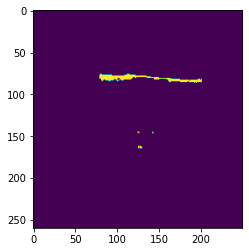

In [4]:
plt.imshow(frames_check[0][0].astype(int))
plt.show()

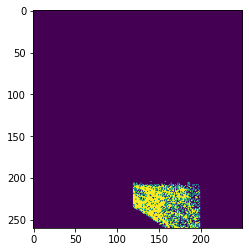

In [3]:
plt.imshow(frames_check[0][1].astype(int))
plt.show()

In [8]:
from utils import *
def int2(num):
    neg = num < 0; pos = num > 0
    num[pos] = (num[pos]*(10**5)+0.5)/(10.**5)
    num[neg] = (num[neg]*(10**5)-0.5)/(10.**5)
    return num.astype(int)

In [2]:
arra = np.arange(-1.2,2,0.4)

In [9]:
int2(arra)

array([-1,  0,  0,  0,  0,  0,  1,  1])

In [4]:
round_int(arra)

array([-1,  0,  0,  0,  0,  0,  1,  1])

In [11]:
%timeit round_int(arra)

4.21 µs ± 84.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [23]:
%timeit np.around(arra).astype(int)

3.59 µs ± 10.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
%timeit np.round(arra).astype(int)

4.51 µs ± 24.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [24]:
%timeit np.rint(arra).astype(int)

1.94 µs ± 16.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [36]:
np.intc(arra)

array([-1, -1,  0,  0,  0,  1,  1,  2], dtype=int32)

In [26]:
def round_arr(arr):
    m = arr % 1. == .5
    arr[m] = np.trunc(arr[m])
    arr[~m] = np.round(arr[~m])
    return arr.astype(int)

In [30]:
%timeit round_arr(arra)

9.86 µs ± 65.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
%timeit np.intc(arra) # nanosecond = 1/1000 microsecond

624 ns ± 15 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
